In [1]:
from fastai.vision.all import *
from fastbook import *

In [2]:
# !pip install librosa

In [3]:
# !wget -P bird/ https://archive.org/download/warblrb10k_public/warblrb10k_public_wav.zip

In [4]:
# from zipfile import ZipFile
# with ZipFile('bird/warblrb10k_public_wav.zip','r') as archive:
#     archive.extractall('birdSound/')

In [2]:
import pandas as pd

In [3]:
label = pd.read_csv('https://ndownloader.figshare.com/files/6035817')

In [4]:
label.head()

,itemid,hasbird
0,759808e5-f824-401e-9058,1
1,1d94fc4a-1c63-4da0-9cac,1
2,bb0099ce-3073-4613-8557,1
3,c4c67e81-9aa8-4af4-8eb7,1
4,ab322d4b-da69-4b06-a065,0


In [5]:
%matplotlib inline
import os
from pathlib import Path
import librosa
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from scipy.io import wavfile

def read_file(filename, path='', sample_rate=None, trim=False):
    ''' Reads in a wav file and returns it as an np.float32 array in the range [-1,1] '''
    filename = Path(path) / filename
    file_sr, data = wavfile.read(filename)
    if data.dtype == np.int16:
        data = np.float32(data) / np.iinfo(np.int16).max
    elif data.dtype != np.float32:
        raise OSError('Encounted unexpected dtype: {}'.format(data.dtype))
    if sample_rate is not None and sample_rate != file_sr:
        if len(data) > 0:
            data = librosa.core.resample(data, file_sr, sample_rate, res_type='kaiser_fast')
        file_sr = sample_rate
    if trim and len(data) > 1:
        data = librosa.effects.trim(data, top_db=40)[0]
    return data, file_sr

In [7]:
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

def transform_path(src_path, dst_path, transform_fn, fnames=None, processes=None, delete=False, **kwargs):
    src_path, dst_path = Path(src_path), Path(dst_path)
    if dst_path.exists() and delete:
        shutil.rmtree(dst_path)
    os.makedirs(dst_path, exist_ok=True)
    
    _transformer = partial(transform_fn, src_path=src_path, dst_path=dst_path, **kwargs)
    if fnames is None:
        fnames = [f.name for f in src_path.iterdir()]
    with Pool(processes=processes) as pool:
        with tqdm(total=len(fnames), unit='files') as pbar:
            for _ in pool.imap_unordered(_transformer, fnames):
                pbar.update()

In [8]:
AUDIO_DIR = Path('birdSound/wav/')
IMG_DIR = Path('imgs2')
# !mkdir {IMG_DIR} -p

In [9]:
fnames = os.listdir(str(AUDIO_DIR))
len(fnames), fnames[:5]

(8000,
 ['8757d0d9-1e34-415e-b830.wav',
  '121b4f2f-e54e-4730-baca.wav',
  'a6ea5026-01cb-42fc-9258.wav',
  'dfdd3720-6ecf-404a-a8a5.wav',
  '72d505af-8afb-4413-9762.wav'])

In [10]:
fn = fnames[58]
print(fn)
Audio(str(AUDIO_DIR/fn))

ed47216b-fbaf-4b95-9707.wav


In [11]:
x, sr = read_file(fn, AUDIO_DIR)
x.shape, sr, x.dtype

((442368,), 44100, dtype('float32'))

In [12]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = read_file(fname, src_path)
    
#     n_fft = 1024
#     hop_length = 256
#     n_mels = 40
#     fmin = 20
#     fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    dst_fname = dst_path / (fname[:-4] + '.png')
    plt.imsave(dst_fname, mel_spec_db)

(128, 865, 4)

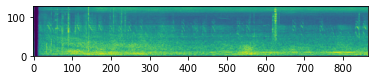

In [13]:
log_mel_spec_tfm(fn, AUDIO_DIR, IMG_DIR)
img = plt.imread(str(IMG_DIR/(fn[:-4] + '.png')))
plt.imshow(img, origin='lower');
img.shape

In [17]:
# transform_path(AUDIO_DIR, IMG_DIR, log_mel_spec_tfm, fnames=fnames, delete=True)

In [14]:
os.listdir(str(IMG_DIR))[:5]

['70d92507-a374-46fb-afc1.png',
 'bc1e1416-f085-4b9f-a1ad.png',
 '430378d5-a0ff-4d0d-b00a.png',
 '68b035bf-3e49-42a2-b76e.png',
 'b9a24561-0bf6-4a30-849b.png']

In [15]:
dblock = DataBlock(blocks = (ImageBlock,CategoryBlock),
                   get_x= ColReader("itemid", suff=".png",pref="imgs2/"),
                   get_y = ColReader("hasbird"),
                   item_tfms= Resize((128,800), method='Crop'),
                   batch_tfms= Normalize.from_stats(*imagenet_stats),
                   splitter = RandomSplitter())
                   

In [16]:
dls = dblock.dataloaders(label)

In [17]:
#  import torch
# torch.cuda.empty_cache()

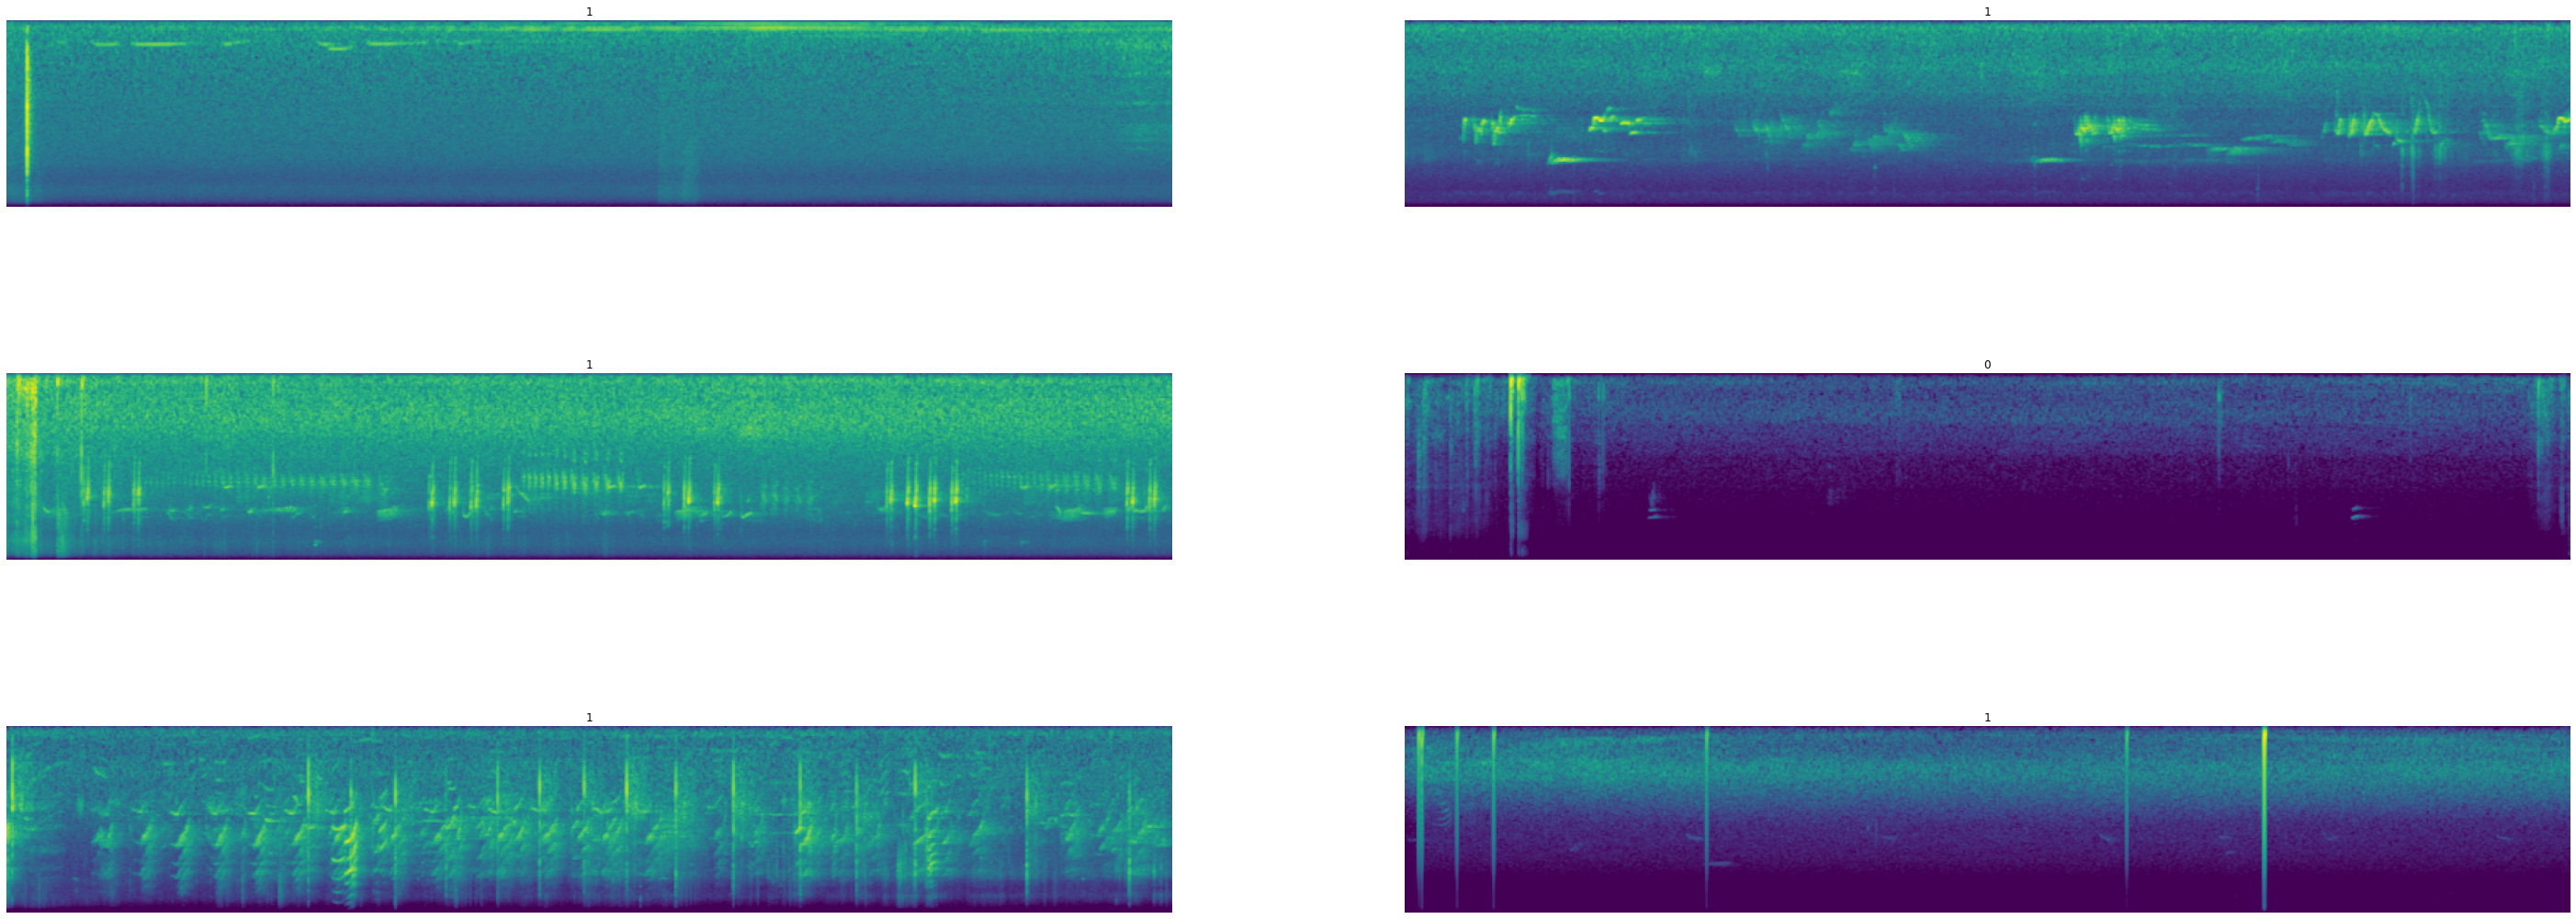

In [59]:
dls.train.show_batch(nrows=3, ncols=2, figsize=(50,20))

In [19]:
learn = cnn_learner(dls, resnet34, metrics = accuracy)

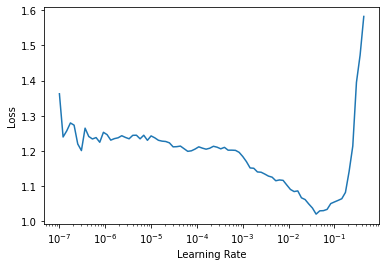

In [20]:
lr_min = learn.lr_find()

In [21]:
lr_min

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.015848932787775993)

In [29]:
# learn.fit_one_cycle(3)
# learn.unfreeze()
# learn.fit_one_cycle(1)
# learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [22]:
learn.fine_tune(2,base_lr= 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.706330,0.455775,0.830000,03:12


epoch,train_loss,valid_loss,accuracy,time
0,0.428367,0.316498,0.863750,04:19
1,0.277596,0.272781,0.884375,04:19


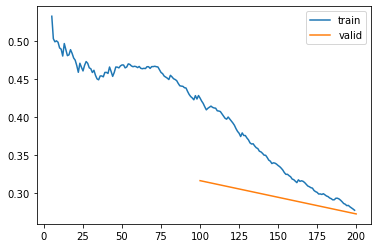

In [23]:
learn.recorder.plot_loss()

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

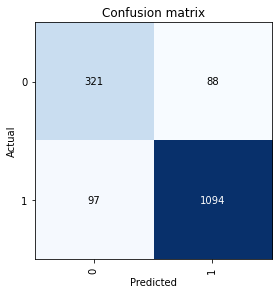

In [25]:
interp.plot_confusion_matrix()

In [26]:
learn.validate()

(#2) [0.2727814316749573,0.8843749761581421]